Εισαγωγή των απαραίτητων modules

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torchtext
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import utils

Φορτώνουμε τα δεδομένα από το train.csv αρχείο

In [2]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Διαχωρισμός των δεομένων σε εκπαίδευση και επικύρωση με ποσοστό 80 - 20
Έπειτα κάνουμε εκκτύπωση των  πρώτων γραμμών των συνόλων για επιβεβαίωση

In [3]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

print(train_data.head())
print(val_data.head())
print(test_data.head())

                             Files     Classes
1665   train/cheesecake/462400.jpg  cheesecake
1416  train/cheesecake/3047613.jpg  cheesecake
7298    train/omelette/1471241.jpg    omelette
4700   train/hamburger/1923024.jpg   hamburger
6192      train/hot_dog/612440.jpg     hot_dog
                            Files    Classes
8432      train/pizza/2468499.jpg      pizza
5680     train/hot_dog/207335.jpg    hot_dog
4767  train/hamburger/2184165.jpg  hamburger
9218      train/sushi/1840999.jpg      sushi
621   train/apple_pie/3365558.jpg  apple_pie
                       Files    Classes
0  test/apple_pie/101251.jpg  apple_pie
1  test/apple_pie/103801.jpg  apple_pie
2  test/apple_pie/110043.jpg  apple_pie
3  test/apple_pie/112378.jpg  apple_pie
4  test/apple_pie/116697.jpg  apple_pie


Με την χρήση της κλάσης Dataset του torch θα δημιουρήσουμε την κλάση FoodDataSet 
Όπου υπάρχει η συνάρτηση αρχικοποίησης 'init' όπου θα ορίσουμε τις παραμέτρους ,
στην 'len' θα επιστρέφεται ο αριθμός των δειγμάτων και στην 'getitem' θα φορτώνεται κάθε εικόνα και θα επιστρέφεται η ετικέτα της. 


In [4]:
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None,classes=None):
        self.dataframe = dataframe
        self.transform = transform
        self.classes = classes
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        label = self.classes[label] 
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

Ορισμός των μετατροπών

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),  # Προσαρμόζουμε αρχικά σε μεγαλύτερη διάσταση για να μην χάνεται ποιότητα
    transforms.CenterCrop(224),  # Κάνουμε crop στο κέντρο για το τελικό μέγεθος
    transforms.ToTensor(),  # Μετατροπή σε tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Κανονικοποίηση σύμφωνα με τα ImageNet standards
])

Δημιουργία των datasets 'train' και 'validation'

In [6]:
train_dataset = FoodDataset(train_data, transform=transform, classes=utils.classes)
val_dataset = FoodDataset(val_data, transform=transform, classes=utils.classes)
test_dataset = FoodDataset(test_data,transform=transform, classes=utils.classes)

Το επόμενο βήμα είναι η δημιουργία των DataLoaders. 
Οι DataLoaders στην PyTorch χειρίζονται τη φόρτωση των δεδομένων από τα Datasets.

In [7]:
# Δημιουργία DataLoader για το training set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# Δημιουργία DataLoader για το validation set
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Δημιουργία DataLoader για το test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [14]:
# # Φόρτωση του πρώτου batch
# images, labels = next(iter(train_loader))

# # Εκτύπωση των διαστάσεων των εικόνων και των ετικετών
# print(f'Batch dimensions: {images.shape}')  # Πρέπει να είναι [64, 3, 224, 224]
# print(f'Labels dimensions: {labels.shape}')  # Πρέπει να είναι [64]

# # Εκτύπωση των ετικετών του πρώτου batch για επαλήθευση
# print(f'Labels: {labels}')

# # Επιλογή και εμφάνιση μιας εικόνας από το batch
# img = images[0].permute(1, 2, 0)  # αλλαγή των διαστάσεων από [C, H, W] σε [H, W, C] για εμφάνιση
# plt.imshow(img)
# plt.title(f'Label: {labels[0]}')
# plt.show()

Λόγω της πολύ αργής επεξεργασίας ολόκληρου dataset δημιουργήθηκε ένα dataframe από 3000 εικόνες για την δοκιμή της λειτουργικότητας. 
Το οποίο ονομάστηκε small_ ώστε να χρησιμοποιηθεί στις παρακάτω συναρτήσεις.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch dimensions: torch.Size([64, 3, 224, 224])
Labels dimensions: torch.Size([64])
Labels: tensor([ 5,  9,  0,  7,  6,  6,  6,  1,  4,  2,  6,  4,  6,  8,  7,  9,  3,  4,
         6,  1,  5,  7,  6,  3,  8, 10,  2,  0,  9,  6,  9, 10,  2,  4,  7,  8,
         2,  5,  8,  3,  2,  6,  8,  0,  8,  0,  5,  4,  7,  7,  1,  0,  5, 10,
         6,  6,  3, 10,  9, 10,  3,  7, 10,  3])


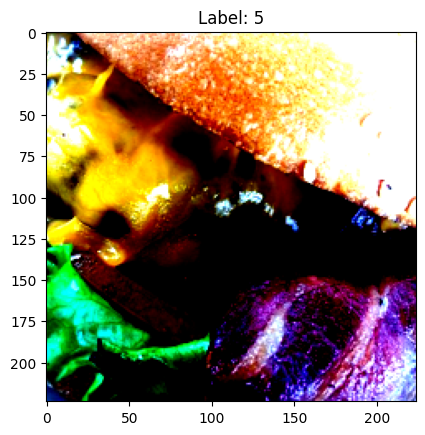

In [8]:
# Επιλογή ενός μικρού αριθμού εικόνων από τα dataframes
small_train_data = train_data.sample(n=3000, random_state=42)
small_val_data = val_data.sample(n=1000, random_state=42)
small_test_data = test_data.sample(n=1000, random_state=42)

# Δημιουργία μικρών Datasets
small_train_dataset = FoodDataset(small_train_data, transform=transform, classes=utils.classes)
small_val_dataset = FoodDataset(small_val_data, transform=transform,classes=utils.classes)
small_test_dataset = FoodDataset(small_test_data, transform=transform,classes=utils.classes)


# Δημιουργία Dataloaders για τα μικρά datasets
small_train_loader = DataLoader(small_train_dataset, batch_size=64, shuffle=True, num_workers=0)
small_val_loader = DataLoader(small_val_dataset, batch_size=64, shuffle=False, num_workers=0)
small_test_loader = DataLoader(small_test_dataset, batch_size=64, shuffle=False, num_workers=0)


# Φόρτωση του πρώτου batch και επαλήθευση
images, labels = next(iter(small_train_loader))
print(f'Batch dimensions: {images.shape}')
print(f'Labels dimensions: {labels.shape}')
print(f'Labels: {labels}')

# Εμφάνιση μιας εικόνας από το batch για επαλήθευση
img = images[0].permute(1, 2, 0)
plt.imshow(img)
plt.title(f'Label: {labels[0]}')
plt.show()


In [ ]:
# def evaluate_model(model, data_loader, criterion):
#     model.eval()  # Ρυθμίζουμε το μοντέλο σε evaluation mode
#     total_loss = 0
#     with torch.no_grad():  # Δεν υπολογίζουμε παραγώγους
#         for images, labels in data_loader:
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item()
#     return total_loss / len(data_loader)

Ορισμός των δύο συναρτήσεων που είναι απαραίτητες για την εκπαίδευση και την αξιολόγηση ενός ΣΝΔ. 
Ορίζεται μια συνάρτηση για εκπαίδευση και μια για αξιολόγηση.

Στην συνάρτηση της εκπαίδευσης δημιουργούνται και επιστρέφονται οι λίστες με τις μετρικές που θα είναι χρήσιμες στα επόμενα βήματα για την αξιολόγηση.

In [9]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(data_loader), correct / total

In [ ]:
# def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
#     train_losses = []
#     val_losses = []
#     for epoch in range(num_epochs):
#         model.train()  # Ρυθμίζουμε το μοντέλο σε training mode
#         train_loss = 0.0
#         for images, labels in train_loader:
#             optimizer.zero_grad()  # Μηδενίζουμε τις παραγώγους
#             outputs = model(images)  # Υπολογισμός προβλέψεων
#             loss = criterion(outputs, labels)  # Υπολογισμός απώλειας
#             loss.backward()  # Υπολογισμός παραγώγων
#             optimizer.step()  # Ενημέρωση βαρών
#             train_loss += loss.item()
#         train_loss /= len(train_loader)
#         train_losses.append(train_loss)

#         # Επικύρωση του μοντέλου
#         val_loss = evaluate_model(model, val_loader, criterion)
#         val_losses.append(val_loss)
        
#         print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

#     return train_losses, val_losses

In [10]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, patience=5):
    model.train()
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    # Λίστες για την αποθήκευση μετρικών
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        
        # Αποθήκευση των μετρικών
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}:')
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping triggered.')
                break
    return train_losses, val_losses, train_accuracies, val_accuracies

"Ποιος ο λόγος που έχουμε κρατήσει ένα κομμάτι του συνόλου εκπαίδευσης ως σύνολο επικύρωσης; ∆ε θα ήταν πιο λογικό να έχουμε περισσότερα δεδομένα για να εκπαιδεύσουμε τα μοντέλα μας;"

Ο πρώτος σημαντικός λόγος είναι η πρόληψη του overfitting. Όταν τα μοντέλα εκπαιδεύονται σε μεγάλα σετ δεδομένων για πολλές εποχές, υπάρχει κίνδυνος να "μάθουν" τόσο καλά τα δεδομένα εκπαίδευσης που απλώς αναπαράγουν τις εισόδους αντί να γενικεύουν σε νέα δεδομένα. 
Επίσης γίνεται βελτιστοποίηση υπερπαραμέτρων όπου το σύνολο επικύρωσης μπορεί να χρησιμοποιηθεί για να αξιολογήσεις διάφορες αρχιτεκτονικές δικτύων ή ρυθμίσεις υπερπαραμέτρων
Τέλος, έχουμε πιο ακριβή εκτίμηση απόδοσης όπου το μοντέλο μπορεί να εκπαιδεύεται καλά στο σύνολο εκπαίδευσης, αλλά η πραγματική αξιολόγηση της απόδοσης του μοντέλου γίνεται σε δεδομένα που δεν έχει "δει" κατά την εκπαίδευση. Το σύνολο επικύρωσης παρέχει μια ανεξάρτητη εκτίμηση της απόδοσης του μοντέλου πριν αυτό δοκιμαστεί στο τελικό σύνολο δοκιμής.

"Τί πρόβλημα καλούμαστε να λύσουμε στο συγκεκριμένο dataset; Ποια είναι η κατάλληλη συνάρτηση
απώλειας για να εκπαιδεύσουμε ένα μοντέλο για ένα τέτοιου είδους προβλήματος;"

Στο dataset μας υπάρχουν πολλαπλές κλάσεις φαγητών (π.χ., apple pie, pizza, sushi κ.ά.), και το μοντέλο μας πρέπει να μάθει να προβλέπει τη σωστή κλάση για κάθε εικόνα.
Για προβλήματα ταξινόμησης με πολλαπλές κλάσεις, η πιο κοινή και κατάλληλη συνάρτηση απώλειας είναι η Cross-Entropy Loss. Αυτή η συνάρτηση είναι ιδιαίτερα χρήσιμη για μέτρηση της απόδοσης ενός μοντέλου ταξινόμησης, το οποίο εκπαιδεύεται σε πολλαπλές κλάσεις και δίνει προβλέψεις ως πιθανότητες.

Εκπαίδευση Συνελικτικών ∆ικτύων

Για την υλοποίηση του συνελικτικού δικτύου SmallNet, πρέπει να ορίσουμε τα διάφορα στρώματα. Θα χρησιμοποιήσουμε τις κλάσεις nn.Conv2d για τα συνελικτικά επίπεδα, nn.MaxPool2d για τα επίπεδα συγκέντρωσης, και nn.Linear για το πλήρως συνδεδεμένο επίπεδο.

In [11]:
class SmallNet(nn.Module):
    def __init__(self, num_classes=11):  
        super(SmallNet, self).__init__()
        # Στρώμα 1: Συνελικτικό
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        # Στρώμα 2: Max Pooling
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Στρώμα 3: Συνελικτικό
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Στρώμα 4: Max Pooling
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Στρώμα 5: Συνελικτικό
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Στρώμα 6: Max Pooling
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Στρώμα 7: Πλήρως συνδεδεμένο
        self.fc = nn.Linear(128 * 28 * 28, num_classes)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(-1, 128 * 28 * 28) 
        x = self.fc(x)
        return x

# Δημιουργία του μοντέλου
model = SmallNet(num_classes=11)  

In [13]:
# Ορισμός μοντέλου, κριτηρίου, βελτιστοποιητή
model = SmallNet(num_classes=11)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)



# Έναρξη της εκπαίδευσης
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, small_train_loader, small_val_loader, num_epochs=30, criterion=criterion, optimizer=optimizer, patience=5)

Epoch 1:
Training Loss: 2.2909, Training Accuracy: 0.18
Validation Loss: 2.1864, Validation Accuracy: 0.23
Epoch 2:
Training Loss: 2.0456, Training Accuracy: 0.31
Validation Loss: 2.0788, Validation Accuracy: 0.28
Epoch 3:
Training Loss: 1.8233, Training Accuracy: 0.41
Validation Loss: 2.0795, Validation Accuracy: 0.29
Epoch 4:
Training Loss: 1.6427, Training Accuracy: 0.48
Validation Loss: 2.0670, Validation Accuracy: 0.31
Epoch 5:
Training Loss: 1.4263, Training Accuracy: 0.57
Validation Loss: 2.1513, Validation Accuracy: 0.29
Epoch 6:
Training Loss: 1.2267, Training Accuracy: 0.63
Validation Loss: 2.2169, Validation Accuracy: 0.30
Epoch 7:
Training Loss: 1.0477, Training Accuracy: 0.69
Validation Loss: 2.1779, Validation Accuracy: 0.30
Epoch 8:
Training Loss: 0.8227, Training Accuracy: 0.78
Validation Loss: 2.3925, Validation Accuracy: 0.28
Epoch 9:
Training Loss: 0.6623, Training Accuracy: 0.83
Validation Loss: 2.5523, Validation Accuracy: 0.27
Early stopping triggered.


Η απώλεια μειώνεται κατά τη διάρκεια της εκπαίδευσης, αλλά υπάρχει μια σαφής αύξηση στην απώλεια επικύρωσης από την 5η "Epoch" και μετά. Αυτό υποδεικνύει ότι το μοντέλο ενδέχεται να υπερεκπαιδεύεται και να μην γενικεύει καλά σε νέα δεδομένα.

Η ακρίβεια αυξάνεται κατά τη διάρκεια της εκπαίδευσης, αλλά ουσιαστικά σταθεροποιείται σε ένα χαμηλό ποσοστό για τα δεδομένα επικύρωσης. Αυτό επιβεβαιώνει ότι το μοντέλο μπορεί να μην έχει επαρκή γενίκευση για να αντιμετωπίσει νέα δεδομένα.

Η αύξηση της ακρίβειας κατά τη διάρκεια της εκπαίδευσης αντικατοπτρίζει την ικανότητα του μοντέλου να μαθαίνει από τα δεδομένα εκπαίδευσης, αλλά η στασιμότητά της στα δεδομένα επικύρωσης υποδηλώνει ότι το μοντέλο ενδέχεται να μην εκτελεί καλά σε νέα, μη εκπαιδευτικά δεδομένα.

Αξιολόγηση

Για την αξιολόγηση του μοντέλου και την οπτικοποίηση των μετρικών, θα χρειαστεί να ακολουθήσουμε μερικά βήματα για να παράγουμε τα απαιτούμενα αποτελέσματα και γραφήματα.

Πρώτα θα ξεκινήσουμε με την οπτικοποίηση των μετρικών εκπαίδευσης. Θα χρησιμοποιήσουμε τη βιβλιοθήκη matplotlib για να δημιουργήσουμε γραφήματα των μετρικών εκπαίδευσης, όπως την απώλεια και την ακρίβεια, για το σύνολο εκπαίδευσης και επικύρωσης. 

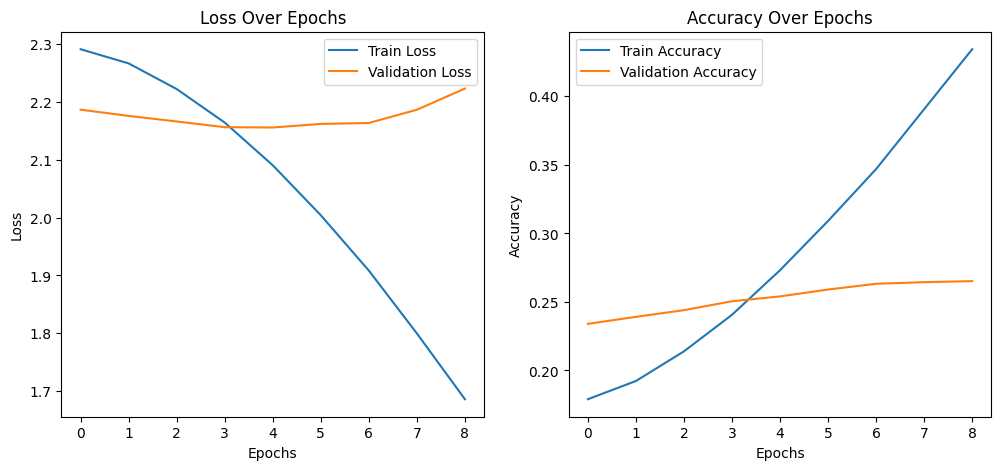

In [14]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, smoothing_factor=0.9):
    smooth_train_losses = utils.smooth(train_losses, smoothing_factor)
    smooth_val_losses = utils.smooth(val_losses, smoothing_factor)
    smooth_train_accs = utils.smooth(train_accuracies, smoothing_factor)
    smooth_val_accs = utils.smooth(val_accuracies, smoothing_factor)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(smooth_train_losses, label='Train Loss')
    plt.plot(smooth_val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(smooth_train_accs, label='Train Accuracy')
    plt.plot(smooth_val_accs, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Το δεύτερο βήμα είναι η δημιουργία της συνάρτησης confusion_matrix. Για την υλοποίηση της συνάρτησης confusion_matrix, θα χρειαστείτε να χρησιμοποιήσετε την torchvision και την sklearn.metrics για να υπολογίσετε τις μετρικές. Θα χρησιμοποιήσουμε τη βιβλιοθήκη sklearn για τον υπολογισμό του πίνακα σύγχυσης και άλλες σχετικές μετρικές όπως accuracy, precision, recall, και f1 score.

get_predictions(): Συλλέγει τις προβλέψεις και τις πραγματικές ετικέτες από το μοντέλο για το δεδομένο υποσύνολο δεδομένων.

confusion_matrix_and_metrics(): Υπολογίζει τον confution matrix και τις βασικές μετρικές απόδοσης (accuracy, precision, recall, f1 score) βάσει των προβλέψεων. Η παράμετρος zero_division=0 χρησιμοποιείται για να αποφύγουμε διαίρεση με μηδέν στην περίπτωση που κάποια κλάση δεν έχει προβλέψεις ή είναι πλήρως λανθασμένη.

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in data_loader:
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

def confusion_matrix_and_metrics(model, data_loader):
    preds, labels = get_predictions(model, data_loader)
    cm = confusion_matrix(labels, preds)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    print("Confusion Matrix:\n", cm)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

    # Επιστροφή των μετρικών
    return cm, accuracy, precision, recall, f1



Confution Matrix για τα δεδομένα του train

In [16]:
cm, accuracy, precision, recall, f1 = confusion_matrix_and_metrics(model, small_train_loader)

Confusion Matrix:
 [[151   9   2   8  46  27   9   1  10  10   5]
 [  0 251   4   2   9   6   2   1   5   2   6]
 [  0   1 242   1  11   3   2   0   2   2   1]
 [  0   0   1 261  11   4   4   0   0   1   1]
 [  0   1   1   0 249   0   2   0   0   0   1]
 [  1   1   3   1  10 251   1   2   2   0   0]
 [  1   1   0   2  13   5 252   2   2   1   1]
 [  0   1   2   0  16   6   4 214   8   6   5]
 [  0   1   1   1  12   7   0   2 236   2   2]
 [  0   1   3   3   8   1   2   2   2 244   2]
 [  0   0   1   0  12   4   2   0   1   3 263]]
Accuracy: 0.87
Precision: 0.89
Recall: 0.87
F1 Score: 0.87


Confution Matrix για τα δεδομένα του validation

In [16]:
cm, accuracy, precision, recall, f1 = confusion_matrix_and_metrics(model, small_val_loader)

Confusion Matrix:
 [[12 14  3  9  1  6 13  6 13  6  1]
 [ 7 62  1  2  1  3  7 15  4  1  2]
 [ 5  9 24  8  1  3  6  5  4  4  2]
 [ 6 13  8 44  1  9 11  3  8  1  1]
 [ 7  5  6  0 26  9  3  7 20  4  2]
 [ 8 23  4  7  5 21  6  4 11  3  1]
 [ 5 14  3 11  4  7 18 14  8  2  1]
 [ 4 22  4  2  2  4  5 27  6  4  5]
 [ 3 15 11  9  6  5 11  6 23  4  2]
 [ 6 15  6  7  1  5  6  7  5 32  6]
 [10 27  5  2  4 10  4  6  5  5 12]]
Accuracy: 0.30
Precision: 0.32
Recall: 0.29
F1 Score: 0.29


4. Συνελικτικό δίκτυο μεγάλου βάθους

Περισσότερα κρυφά επίπεδα
Για την προσθήκη κρυφών επιπέδων σε ένα νευρωνικό δίκτυο, θα επεκτείνουμε την αρχιτεκτονική του μοντέλου SmallNet που χρησιμοποιήσαμε νωρίτερα, προσθέτοντας περισσότερα επίπεδα για να αυξήσουμε την ικανότητά του να μαθαίνει πιο σύνθετα χαρακτηριστικά. 

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class EnhancedSmallNet(nn.Module):
    def __init__(self, num_classes=11):
        super(EnhancedSmallNet, self).__init__()
        # Πρώτο συνελικτικό επίπεδο
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Δεύτερο συνελικτικό επίπεδο
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Τρίτο συνελικτικό επίπεδο
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Πλήρως συνδεδεμένο επίπεδο
        self.fc = nn.Linear(128 * 28 * 28, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = x.view(-1, 128 * 28 * 28)  # Flatten the layer
        x = self.fc(x)
        return x


Για να τρέξουμε το παραπάνω μοντέλο θα πρέπει να δημιουργηθεί μια οντότητα του μοντέλου και να το εκπαιδεύσετε με τα αντίστοιχα DataLoader.

In [18]:
# Δημιουργία του μοντέλου
enhanced_model = EnhancedSmallNet(num_classes=11)  

# Επιλογή του device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enhanced_model = enhanced_model.to(device)

# Ορισμός του βελτιστοποιητή και τη συνάρτηση απώλειας
optimizer = optim.Adam(enhanced_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

Εκπαίδευση του μοντέλου χρησιμοποιόντας τη συνάρτηση train_model που έχει προηγουμένως οριστεί.

Epoch 1:
Training Loss: 2.3769, Training Accuracy: 0.13
Validation Loss: 2.3075, Validation Accuracy: 0.15
Epoch 2:
Training Loss: 2.2348, Training Accuracy: 0.22
Validation Loss: 2.2095, Validation Accuracy: 0.23
Epoch 3:
Training Loss: 2.1187, Training Accuracy: 0.26
Validation Loss: 2.1924, Validation Accuracy: 0.22
Epoch 4:
Training Loss: 1.9974, Training Accuracy: 0.33
Validation Loss: 2.1804, Validation Accuracy: 0.26
Epoch 5:
Training Loss: 1.8218, Training Accuracy: 0.40
Validation Loss: 2.2114, Validation Accuracy: 0.24
Epoch 6:
Training Loss: 1.5410, Training Accuracy: 0.49
Validation Loss: 2.3494, Validation Accuracy: 0.24
Epoch 7:
Training Loss: 1.1605, Training Accuracy: 0.62
Validation Loss: 2.6244, Validation Accuracy: 0.24
Epoch 8:
Training Loss: 0.7555, Training Accuracy: 0.77
Validation Loss: 3.1565, Validation Accuracy: 0.22
Epoch 9:
Training Loss: 0.4205, Training Accuracy: 0.87
Validation Loss: 4.4821, Validation Accuracy: 0.21
Early stopping triggered.


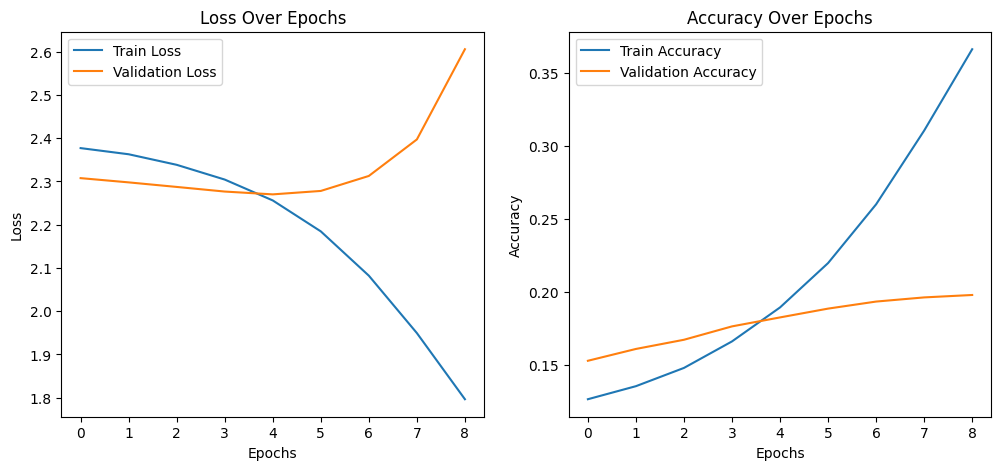

In [19]:
num_epochs = 30  

# Κλήση της συνάρτησης εκπαίδευσης
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    enhanced_model, 
    small_train_loader, 
    small_val_loader, 
    num_epochs, 
    criterion, 
    optimizer, 
    patience=5  # Early stopping αν δεν βελτιωθεί η απώλεια επικύρωσης για 5 εποχές
)

# Οπτικοποίηση των μετρικών
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


Όπως φαίνεται, το μοντέλο εμφανίζει μια αρκετά χαμηλή απώλεια εκπαίδευσης και επικύρωσης στην αρχή, αλλά μετά την πρώτη εποχή η απώλεια αυξάνεται σημαντικά και η ακρίβεια παραμένει σε χαμηλά επίπεδα. Αυτό υποδεικνύει ότι το μοντέλο δεν είναι ικανό να μάθει αποτελεσματικά από τα δεδομένα εκπαίδευσης.
Η αύξηση του αριθμού των συνελικτικών επιπέδων φαίνεται να μην έχει ουσιαστικό αντίκτυπο στην απόδοση του μοντέλου. Παρόλο που η αρχιτεκτονική είναι πιο πολύπλοκη, η αύξηση του βάθους δεν φαίνεται να οδηγεί σε βελτίωση των αποτελεσμάτων.
Το μοντέλο φαίνεται να αντιμετωπίζει προβλήματα με υπερεκπαίδευση, καθώς η απώλεια επικύρωσης αυξάνεται συνεχώς και η ακρίβεια σταθεροποιείται σε χαμηλά επίπεδα. Αυτό υποδεικνύει ότι το μοντέλο δεν είναι αρκετά ισχυρό για να γενικεύσει αποτελεσματικά σε νέα δεδομένα. 

Περισσότερα πλήρως συνδεδεμένα επίπεδα: 

In [20]:
class DeepFCNet(nn.Module):
    def __init__(self, num_classes=11):
        super(DeepFCNet, self).__init__()
        # Συνελικτικά επίπεδα
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Πλήρως συνδεδεμένα επίπεδα
        self.fc1 = nn.Linear(128 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)  
        self.fc3 = nn.Linear(512, 256)   
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(-1, 128 * 28 * 28)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [21]:
# Δημιουργία του μοντέλου
deep_fc_model = DeepFCNet(num_classes=11)  

# Επιλογή του device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deep_fc_model = deep_fc_model.to(device)

# Ορισμός του βελτιστοποιητή και τη συνάρτηση απώλειας
optimizer = optim.Adam(deep_fc_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

Epoch 1:
Training Loss: 2.3350, Training Accuracy: 0.14
Validation Loss: 2.2420, Validation Accuracy: 0.20
Epoch 2:
Training Loss: 2.1874, Training Accuracy: 0.22
Validation Loss: 2.1640, Validation Accuracy: 0.24
Epoch 3:
Training Loss: 2.0377, Training Accuracy: 0.30
Validation Loss: 2.0848, Validation Accuracy: 0.28
Epoch 4:
Training Loss: 1.8675, Training Accuracy: 0.37
Validation Loss: 2.1647, Validation Accuracy: 0.26
Epoch 5:
Training Loss: 1.7206, Training Accuracy: 0.43
Validation Loss: 2.1339, Validation Accuracy: 0.29
Epoch 6:
Training Loss: 1.5362, Training Accuracy: 0.49
Validation Loss: 2.1148, Validation Accuracy: 0.28
Epoch 7:
Training Loss: 1.2962, Training Accuracy: 0.59
Validation Loss: 2.1834, Validation Accuracy: 0.31
Epoch 8:
Training Loss: 1.0782, Training Accuracy: 0.65
Validation Loss: 2.3681, Validation Accuracy: 0.29
Early stopping triggered.


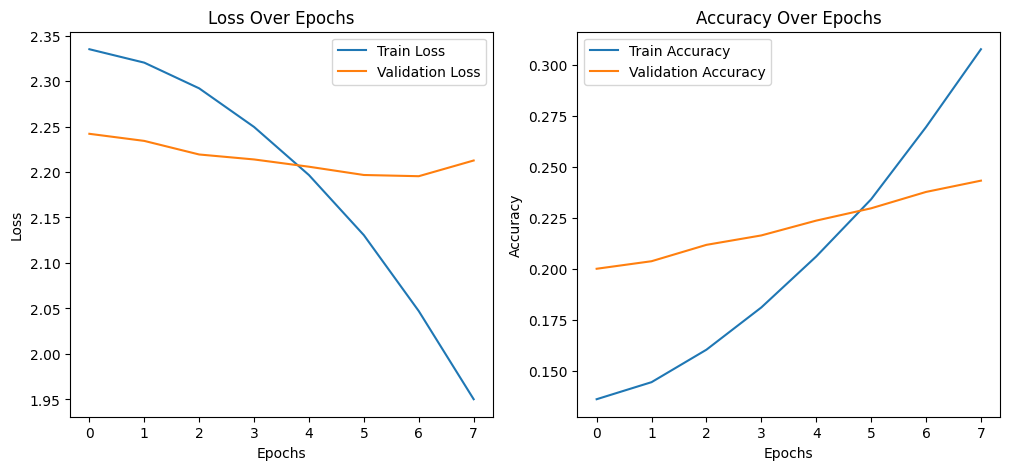

In [22]:
num_epochs = 30  

# Κλήση της συνάρτησης εκπαίδευσης
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    deep_fc_model, 
    small_train_loader, 
    small_val_loader, 
    num_epochs, 
    criterion, 
    optimizer, 
    patience=5  # Early stopping
)

# Οπτικοποίηση των μετρικών
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


Παρόμοια με το προηγούμενο μοντέλο, το μοντέλο φαίνεται να αντιμετωπίζει προβλήματα υπερεκπαίδευσης. Η απώλεια εκπαίδευσης μειώνεται αρχικά, αλλά στη συνέχεια αυξάνεται, ενώ η ακρίβεια επικύρωσης παραμένει σε χαμηλά επίπεδα. Αυτό υποδηλώνει ότι το μοντέλο δεν είναι ικανό να γενικεύσει αποτελεσματικά σε νέα δεδομένα.

Η προσθήκη περισσότερων πλήρως συνδεδεμένων επιπέδων στο τέλος του μοντέλου δεν φαίνεται να έχει σημαντική επίδραση στην απόδοση. Παρόλο που η αρχιτεκτονική είναι πιο πολύπλοκη, η αύξηση του βάθους δεν οδηγεί σε βελτίωση των αποτελεσμάτων.

Το μοντέλο επίσης φαίνεται να αντιμετωπίζει προβλήματα με υπερεκπαίδευση, και η αύξηση του αριθμού των πλήρως συνδεδεμένων επιπέδων δεν φαίνεται να βελτιώνει την απόδοση.

Προεκπαιδευμένο Νευρωνικό ∆ίκτυο

Αρχικά, θα φορτώσουμε το προεκπαιδευμένο μοντέλο και θα τροποποιηθεί με το τελευταίο πλήρως συνδεδεμένο επίπεδο 

In [12]:
from torchvision.models import resnet50, ResNet50_Weights

# Αρχικοποίηση του μοντέλου με τα καλύτερα διαθέσιμα βάρη
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Τροποποίηση του τελευταίου FC επιπέδου
num_classes = 11 
model.fc = nn.Linear(model.fc.in_features, num_classes)


Ορισμός ενός βελτιστοποιητή και μιας συνάρτηση απώλειας.

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)  
criterion = nn.CrossEntropyLoss()

In [14]:
smaller_train_data = train_data.sample(n=500, random_state=42)
smaller_val_data = val_data.sample(n=50, random_state=42)

# Δημιουργία μικρών Datasets
smaller_train_dataset = FoodDataset(smaller_train_data, transform=transform, classes=utils.classes)
smaller_val_dataset = FoodDataset(smaller_val_data, transform=transform,classes=utils.classes)


# Δημιουργία Dataloaders για τα μικρά datasets
smaller_train_loader = DataLoader(smaller_train_dataset, batch_size=64, shuffle=True, num_workers=0)
smaller_val_loader = DataLoader(smaller_val_dataset, batch_size=64, shuffle=False, num_workers=0)


Εξαιτείας της απουσίας κάρτας γραφικών από τον υπολογιστή μου μετά από 2,5 περίπου ώρες το kernel σταμάτησε με μήνυμα : "The Kernel crashed while executing code in the current cell or a previous cell. 

Please review the code in the cell(s) to identify a possible cause of the failure. "

Έτσι δημιουργήθηκε ένα ακόμα μικρότερο dataset (smaller_) ώστε να μπορέσω να τρέξω το μοντέλο. 
Ακόμα και με το μικρό δείγμα από τα δεδομένα δεν μπορούσε να τρέξει και μετά από αρκετή ώρα το kernel σταματούσε να λειτουργεί.

In [15]:

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, smaller_train_loader, smaller_val_loader, 30, criterion, optimizer, 5  
)

# Αξιολόγηση στο test set
test_loss, test_accuracy = evaluate_model(model, smaller_train_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}")


Epoch 1:
Training Loss: 2.3796, Training Accuracy: 0.15
Validation Loss: 2.3201, Validation Accuracy: 0.22
Epoch 2:
Training Loss: 1.9567, Training Accuracy: 0.83
Validation Loss: 2.1556, Validation Accuracy: 0.44
Epoch 3:
Training Loss: 1.5312, Training Accuracy: 0.95
Validation Loss: 1.9078, Validation Accuracy: 0.56
Epoch 4:
Training Loss: 1.1282, Training Accuracy: 0.98
Validation Loss: 1.5414, Validation Accuracy: 0.60
Epoch 5:
Training Loss: 0.7458, Training Accuracy: 0.99
Validation Loss: 1.2425, Validation Accuracy: 0.72
Epoch 6:
Training Loss: 0.4303, Training Accuracy: 1.00
Validation Loss: 1.0515, Validation Accuracy: 0.72
Epoch 7:
Training Loss: 0.2322, Training Accuracy: 1.00
Validation Loss: 0.9320, Validation Accuracy: 0.74
Epoch 8:
Training Loss: 0.1151, Training Accuracy: 1.00
Validation Loss: 0.8397, Validation Accuracy: 0.74
Epoch 9:
Training Loss: 0.0568, Training Accuracy: 1.00
Validation Loss: 0.7876, Validation Accuracy: 0.76
Epoch 10:
Training Loss: 0.0314, Trai

Η απώλεια μειώνεται σταθερά κατά τη διάρκεια της εκπαίδευσης, ενώ η ακρίβεια αυξάνεται σημαντικά. Το μοντέλο φαίνεται να μάθαινει αποτελεσματικά από τα δεδομένα εκπαίδευσης και να γενικεύει καλά σε νέα δεδομένα.

Η χρήση ενός προεκπαιδευμένου μοντέλου όπως το ResNet-50 είναι πιθανό να έχει συμβάλλει σημαντικά στη βελτίωση της απόδοσης. Η προεκπαίδευση σε μεγάλα σύνολα δεδομένων όπως το ImageNet έχει συχνά ως αποτέλεσμα μοντέλα που μπορούν να γενικεύουν καλά σε διάφορα προβλήματα.

Παρόλο που η ακρίβεια εκπαίδευσης φτάνει το 100%, η ακρίβεια επικύρωσης δεν φαίνεται να συγκλίνει πλήρως στο 100%, υποδεικνύοντας πιθανή υπερεκπαίδευση..